# Setup

## Notebook Environments

### Colab

Colab initialization requires a kernel restart. So we do it at the beginning of the notebook.

In [141]:
import os

In [142]:
_is_colab = 'COLAB_GPU' in os.environ

Colab only allows one conda environment. We use `conda-colab` to install an anaconda style environment from a constructor style `.sh` file. See the `.environment` sub folder for instructions.

Colab kernel is restarted after the environment is installed.

In [143]:
if _is_colab:
    %pip install -q condacolab
    import condacolab
    condacolab.install_from_url("https://github.com/restlessronin/lila-reports/releases/download/v0.0.2/conda-lila-reports-0.0.2-Linux-x86_64.sh")

Since colab runtime is restarted by the previous cell, we need to reset globals

In [144]:
import os
_is_colab = 'COLAB_GPU' in os.environ

In colab we can mount data files directly from google drive.

In [145]:
if _is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

### Kaggle

Kaggle uses Dockerfiles to define environments, so we wind up using `pip` to install missing packages.

In [146]:
_is_kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE','')
if _is_kaggle:
    %pip install -q matplotlib_scalebar

### Local

For local notebooks, we use a conda environment created from `.environment/environment.yaml` to run the notebook. No package installation is necessary.

## Imports

In [147]:
import sys, subprocess,time
import pandas as pd
import numpy as np
import geopandas as gpd
from pyproj import CRS
from shapely.ops import unary_union, polygonize
from rtree import index
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
import rasterio
#import rasterstats as rs
import glob
from shapely.affinity import rotate
from shapely.geometry import LineString, Point, MultiPolygon,MultiLineString 
from shapely.ops import unary_union, polygonize
from geopandas import overlay
import shapely.wkt
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib_scalebar.scalebar import ScaleBar

from pathlib import Path

## Input and Working Dir paths

Since inputs data may be read-only, we separate path abstractions for inputs and working directories. The path are wrapped in function calls, so this is the only cell which needs to be modified when the notebook runtime folders are changed.

In [148]:
def get_input(stem):
    return "D:/LiLa_Nagapattinam/" + stem

def get_in_workdir(stem):
    if _is_kaggle or _is_colab:
        return './' + stem
    else:
        return get_input('workdir/' + stem)

def read_df_UT(stem):
    return gpd.read_file(get_input(stem)).to_crs(epsg = 4326)


# Creating Visuals for Lila Solar Report

## District shape

In [149]:
_shp_district = read_df_UT("Practice/Nagapattinam_proj32644.shp")
_shp_district.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA        1 non-null      float64 
 1   PERIMETER   1 non-null      float64 
 2   DISTRICT_   1 non-null      int64   
 3   DISTRICT_I  1 non-null      int64   
 4   DCODE       1 non-null      object  
 5   DISTRICT    1 non-null      object  
 6   SCODE       1 non-null      object  
 7   STATE       1 non-null      object  
 8   SDCODE      1 non-null      object  
 9   AREAHA      1 non-null      float64 
 10  geometry    1 non-null      geometry
dtypes: float64(3), geometry(1), int64(2), object(5)
memory usage: 216.0+ bytes


## Powerlines

In [150]:
_shp_powerlines = read_df_UT("Supporting_info/osm_powline_11.776643009779821_10.743913945502888_80.19273383153288_79.14689901832789.geojson")

In [151]:
_shp_powerlines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cables                    192 non-null    object  
 1   power                     196 non-null    object  
 2   voltage                   191 non-null    object  
 3   note                      2 non-null      object  
 4   building                  0 non-null      object  
 5   operator                  0 non-null      object  
 6   substation                0 non-null      object  
 7   frequency                 0 non-null      object  
 8   location                  0 non-null      object  
 9   generator:source          0 non-null      object  
 10  name                      0 non-null      object  
 11  plant:method              0 non-null      object  
 12  plant:output:electricity  0 non-null      object  
 13  plant:source              0 non-null      

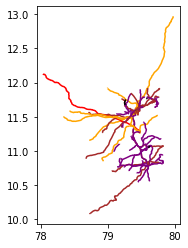

In [152]:
_shp_powerlines.plot(color = _shp_powerlines["color"])
plt.show()

In [153]:
_shp_dst_powerlines = overlay(_shp_powerlines, _shp_district, how='intersection')
_shp_dst_powerlines.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cables                    25 non-null     object  
 1   power                     25 non-null     object  
 2   voltage                   24 non-null     object  
 3   note                      0 non-null      object  
 4   building                  0 non-null      object  
 5   operator                  0 non-null      object  
 6   substation                0 non-null      object  
 7   frequency                 0 non-null      object  
 8   location                  0 non-null      object  
 9   generator:source          0 non-null      object  
 10  name                      0 non-null      object  
 11  plant:method              0 non-null      object  
 12  plant:output:electricity  0 non-null      object  
 13  plant:source              0 non-null      ob

## Substations

In [154]:
_shp_substations = read_df_UT("Supporting_info/list_substation_TN_corr.geojson/list_substation_TN_corr.shp")
_shp_dst_substations = overlay(_shp_substations, _shp_district, how='intersection')

## Composite plot - Substation + Powerlines

This plot layers the powerlines and substation locations in the district.
Details of the library can be found here : https://geopandas.org/en/stable/docs/user_guide/mapping.html

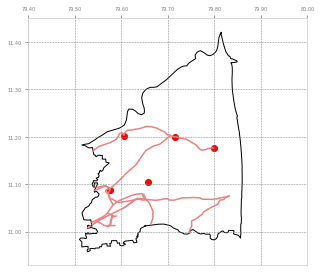

In [181]:
_plt_district = _shp_district.plot(figsize=(5,5),color="none")
_shp_dst_powerlines.plot(color="lightcoral",ax =_plt_district) 
_shp_dst_substations.plot(color="red",ax=_plt_district)  

_plt_district.xaxis.tick_top()

plt.xlim(79.40,80.00) 
plt.ylim(10.93,11.45)  

plt.grid(color="grey",linestyle = '--', linewidth = 0.5) 

_plt_district.tick_params(axis='x', colors='grey',labelsize=5) 
_plt_district.tick_params(axis='y', colors='grey',labelsize=5)

_plt_district.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
_plt_district.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

_plt_district.spines['bottom'].set_color('lightgrey') 
_plt_district.spines['top'].set_color('lightgrey') 
_plt_district.spines['right'].set_color('lightgrey')
_plt_district.spines['left'].set_color('lightgrey')

# plt.savefig(get_in_workdir("powerlines.jpg"),dpi =1500) 
plt.show()

In [156]:
_shp_dst_substations.head()

,Name of th,Voltage ra,Capacity i,Date of Co,AREA,PERIMETER,DISTRICT_,DISTRICT_I,DCODE,DISTRICT,SCODE,STATE,SDCODE,AREAHA,geometry
0,Kadalangudy,110/11,1x16,25.01.02,1.199284e+09,206966.913791,983,977,19,Nagapattinam,33,Tamil Nadu,3319,119928.431631,POINT (79.57505 11.08840)
1,Manalmedu,110/33-11,"1x10, 2X10",17.02.88,1.199284e+09,206966.913791,983,977,19,Nagapattinam,33,Tamil Nadu,3319,119928.431631,POINT (79.60593 11.20177)
2,Mayiladuthurai,110/33-11,"1x10+1X16, 2x16",07.10.79,1.199284e+09,206966.913791,983,977,19,Nagapattinam,33,Tamil Nadu,3319,119928.431631,POINT (79.65633 11.10438)
3,Thiruvengadu,110/11,1x10,31.03.03,1.199284e+09,206966.913791,983,977,19,Nagapattinam,33,Tamil Nadu,3319,119928.431631,POINT (79.79977 11.17567)
4,Vaitheeswarankoil,110/33-11,1x16+1x16,14.12.01,1.199284e+09,206966.913791,983,977,19,Nagapattinam,33,Tamil Nadu,3319,119928.431631,POINT (79.71628 11.19915)


## Roads - Primary and Secondary 

<AxesSubplot:>

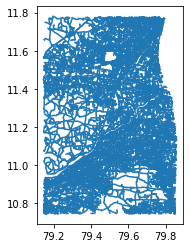

In [182]:
_shp_roads = read_df_UT("Supporting_info/output_osmroad_edges_11.776643009779821_10.743913945502888_80.19273383153288_79.14689901832789.geojson/edges.shp")
_shp_roads.plot()

In [183]:
_shp_roads.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 145510 entries, 0 to 145509
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   u         145510 non-null  int64   
 1   v         145510 non-null  int64   
 2   key       145510 non-null  int64   
 3   osmid     145510 non-null  object  
 4   highway   145510 non-null  object  
 5   oneway    145510 non-null  int64   
 6   length    145510 non-null  float64 
 7   from      145510 non-null  int64   
 8   to        145510 non-null  int64   
 9   bridge    1879 non-null    object  
 10  ref       11007 non-null   object  
 11  name      15152 non-null   object  
 12  lanes     2152 non-null    object  
 13  tunnel    37 non-null      object  
 14  maxspeed  1658 non-null    object  
 15  service   268 non-null     object  
 16  width     184 non-null     object  
 17  junction  202 non-null     object  
 18  access    162 non-null     object  
 19  geometry  14551

In [184]:
_shp_roads.head()

,u,v,key,osmid,highway,oneway,length,from,to,bridge,ref,name,lanes,tunnel,maxspeed,service,width,junction,access,geometry
0,114249070,1684594150,0,156177431,unclassified,0,359.100,1684594150,114249070,None,None,None,None,None,None,None,None,None,None,"LINESTRING (79.85376 11.07422, 79.85705 11.07409)"
1,705159214,2533158270,0,"[246256852, 246256861, 246256846]",tertiary,0,1955.792,2533158270,705159214,yes,None,None,None,None,None,None,None,None,None,"LINESTRING (79.84985 10.99956, 79.84978 10.999..."
2,705159214,2470898606,0,"[239290553, 239290558]",trunk,0,235.723,2470898606,705159214,yes,NH32,East Coast Road,2,None,None,None,None,None,None,"LINESTRING (79.83408 11.00370, 79.83386 11.003..."
3,705159214,6079883062,0,239290558,trunk,0,295.306,6079883062,705159214,None,NH32,East Coast Road,None,None,None,None,None,None,None,"LINESTRING (79.83048 11.00171, 79.83050 11.001..."
4,705159371,2531848404,0,239290554,trunk,0,15.256,2531848404,705159371,None,NH32,East Coast Road,2,None,None,None,None,None,None,"LINESTRING (79.84215 11.01963, 79.84219 11.01976)"


In [185]:
_shp_roads.shape

(145510, 20)

In [186]:
_shp_roads["highway"].unique()

array(['unclassified', 'tertiary', 'trunk', 'secondary', 'residential',
       'primary', 'path', "['residential', 'service']", 'living_street',
       'footway', 'service', "['path', 'unclassified']",
       "['residential', 'track']", 'track', 'road',
       "['unclassified', 'track']", "['residential', 'unclassified']",
       "['steps', 'footway']", "['residential', 'path']",
       "['unclassified', 'path']", "['unclassified', 'primary']",
       'trunk_link', "['tertiary', 'track']", 'primary_link',
       "['tertiary', 'unclassified']", "['residential', 'living_street']",
       "['residential', 'road']",
       "['residential', 'unclassified', 'path']",
       "['residential', 'tertiary', 'unclassified']", "['road', 'path']",
       "['unclassified', 'service']", "['living_street', 'unclassified']",
       "['secondary', 'tertiary']", "['road', 'track']",
       "['road', 'path', 'track']", "['road', 'unclassified']",
       "['footway', 'unclassified']", "['service', 'track']"

In [191]:
_shp_roads_secondary = _shp_roads.apply(lambda row: row[_shp_roads['highway'].isin(['secondary'])])
_shp_roads_primary = _shp_roads.apply(lambda row: row[_shp_roads['highway'].isin(['primary'])])

_shp_dst_roads_secondary = overlay(_shp_roads_secondary,_shp_district,how ="intersection")
_shp_dst_roads_primary = overlay(_shp_roads_primary,_shp_district,how ="intersection")

## Railways

<AxesSubplot:>

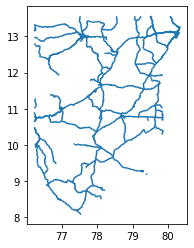

In [190]:
_shp_railways = read_df_UT("Supporting_info/railway/Railways.shp")
_shp_railways.plot()

In [193]:
_shp_dst_railways = overlay(_shp_railways,_shp_district,how ="intersection")

<AxesSubplot:>

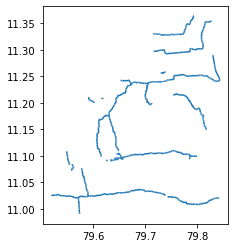

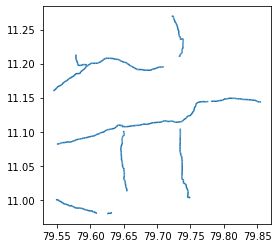

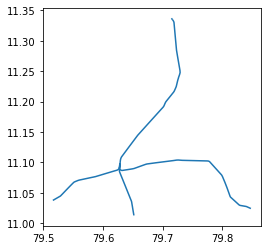

In [194]:
_shp_dst_roads_secondary.plot()
_shp_dst_roads_primary.plot()
_shp_dst_railways.plot()

## Composite plot - Roads (Primary & Secondary) + Railways

This plot layers the primary and secondary roads with the railway lines in the district.
Details of the library can be found here : https://geopandas.org/en/stable/docs/user_guide/mapping.html

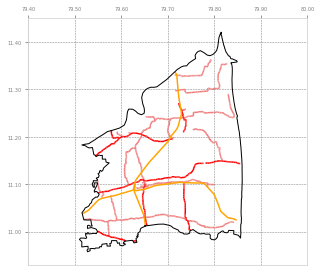

In [195]:
_plt_district = _shp_district.plot(figsize=(5,5),color="none",zorder=3)
_shp_dst_roads_secondary.plot(color="lightcoral",label ="Secondary roads",ax =_plt_district)
_shp_dst_roads_primary.plot(color="red",label ="Primary roads",ax=_plt_district)
_shp_dst_railways.plot(color="orange",label ="Railway roads",ax=_plt_district)

_plt_district.xaxis.tick_top()

plt.xlim(79.40,80.00)
plt.ylim(10.93,11.45)

plt.grid(color="grey",linestyle = '--', linewidth = 0.5)

_plt_district.tick_params(axis='x', colors='grey', labelsize=5)
_plt_district.tick_params(axis='y', colors='grey', labelsize=5)

_plt_district.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
_plt_district.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

_plt_district.spines['bottom'].set_color('lightgrey')
_plt_district.spines['top'].set_color('lightgrey') 
_plt_district.spines['right'].set_color('lightgrey')
_plt_district.spines['left'].set_color('lightgrey')

# _plt_district.savefig(get_in_workdir("roadway.jpg"),dpi =1500)
plt.show()

## Water Bodies

In [196]:
_shp_water = read_df_UT("Practice/water_TN.shp")
_shp_dst_water = overlay(_shp_water,_shp_district,how ="intersection")

This plot shows the water bodies within the boundaries of the district.
Details of the library can be found here : https://geopandas.org/en/stable/docs/user_guide/mapping.html

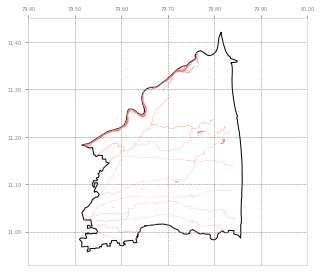

In [197]:
_plt_district = _shp_district.plot(figsize=(5,5),color="none",zorder=1)

_shp_dst_water.plot(color="lightcoral",ax =_plt_district)

_plt_district.xaxis.tick_top()

plt.xlim(79.40,80.00)
plt.ylim(10.93,11.45)

plt.grid(color="grey",linestyle = '--', linewidth = 0.50)

_plt_district.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
_plt_district.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

_plt_district.tick_params(axis='x', colors='grey', labelsize=5)
_plt_district.tick_params(axis='y', colors='grey', labelsize=5)

_plt_district.spines['bottom'].set_color('lightgrey')
_plt_district.spines['top'].set_color('lightgrey') 
_plt_district.spines['right'].set_color('lightgrey')
_plt_district.spines['left'].set_color('lightgrey')

# plt.savefig(get_in_workdir("water.jpg"),dpi =1500)
plt.show()

In [172]:
def read_raster_UT_path(path):
    return rasterio.open(path)

def read_raster_UT(stem):
    return read_raster_UT_path(get_input(stem))

In [173]:
raster = read_raster_UT("Supporting_info/GHI_Nagapattinam.tif")

In [174]:
raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': 1.1754943508222875e-38,
 'width': 142,
 'height': 189,
 'count': 1,
 'crs': CRS.from_epsg(32644),
 'transform': Affine(268.00554929577464, 0.0, 337343.3605,
        0.0, -268.00554920634914, 1262584.7596)}

In [175]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [176]:
raster.crs

CRS.from_epsg(32644)

In [177]:
dstCrs = {'init': 'EPSG:4326'}

In [178]:
#calculate transform array and shape of reprojected raster
transform, width, height = calculate_default_transform(
        raster.crs, dstCrs, raster.width, raster.height, *raster.bounds)

raster.transform
transform

Affine(0.0024345716594621186, 0.0, 79.50908552594798,
       0.0, -0.0024345716594621186, 11.419269071660535)

In [179]:
#working of the meta for the destination raster
kwargs = raster.meta.copy()
kwargs.update({
        'crs': dstCrs,
        'transform': transform,
        'width': width,
        'height': height,
    })

In [180]:
def open_raster_to_write(fname, kwargs):
    dstPath = get_in_workdir(fname)
    if os.path.exists(dstPath):
        os.remove(dstPath)
    return rasterio.open(dstPath, 'w', **kwargs)

dstRst = open_raster_to_write('GHIepsg_Nagapattinam.tif', kwargs)

PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:/LiLa_Nagapattinam/workdir/GHIepsg_Nagapattinam.tif'

In [ ]:
dstRst.meta

In [ ]:
#reproject and save raster band data
for i in range(1, raster.count + 1):
    reproject(
        source=rasterio.band(raster, i),
        destination=rasterio.band(dstRst, i),
        #src_transform=srcRst.transform,
        src_crs=raster.crs,
        #dst_transform=transform,
        dst_crs=dstCrs,
        resampling=Resampling.nearest)

#close destination raster
dstRst.close()        

In [ ]:
import rasterio
from rasterio.plot import show
dstRst = read_raster_UT_path(get_in_workdir('GHIepsg_Nagapattinam.tif'))
show(dstRst)

land cover high, med, low

In [ ]:
lc_high = read_df_UT('solar/_rl_elev_rd_wat_co_trans_ar_sub_rdpx_trsub_trat_subat_rdat_ir_high/LC_Solar_final_area_mask_1_Nagapattinam.shp')

In [ ]:
lc_med = read_df_UT("solar/_rl_elev_rd_wat_co_trans_ar_sub_rdpx_trsub_trat_subat_rdat_ir_medatt/LC_Solar_final_area_mask_1_Nagapattinam.shp")

In [ ]:
lc_low = read_df_UT('solar/_rl_elev_rd_wat_trans_ar_sub_rdpx_trsub_low/LC_Solar_final_area_mask_1_Nagapattinam.shp')

In [ ]:
merge_lc1 = overlay(lc_high,_shp_district,how ="intersection")
merge_lc2 = overlay(lc_med,_shp_district,how ="intersection")
merge_lc3 = overlay(lc_low,_shp_district,how ="intersection")


In [ ]:
merge_lc3.head()

In [ ]:
ax = _shp_district.plot(figsize=(5,5),color="none",zorder=3)
x = merge_lc3.plot(color="yellow",ax =ax)
y = merge_lc2.plot(color="red",ax =ax)
z = merge_lc1.plot(color="green",ax =ax)
ax.xaxis.tick_top()
plt.xlim(79.40,80.00)
plt.ylim(10.93,11.45)
plt.grid(color="grey",linestyle = '--', linewidth = 0.50)
# plt.legend(loc="lower right")
plt.ticklabel_format(axis="both")
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis='x', colors='grey')
ax.tick_params(axis='y', colors='grey')
ax.add_artist(ScaleBar(1))
ax.tick_params(axis='x', labelsize=5)
ax.tick_params(axis='y', labelsize=5)
x1, y1, arrow_length = 0.5, 1.2, 0.09
ax.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
            arrowprops=dict(facecolor='none', width=3, headwidth=12),
            ha='center', va='center', fontsize=10,
            xycoords=ax.transAxes)
ax.spines['bottom'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey') 
ax.spines['right'].set_color('lightgrey')
ax.spines['left'].set_color('lightgrey')
plt.savefig("lc.jpg",dpi =1500)
# plt.axis('off')
plt.show()

In [ ]:
lc_tech = read_df_UT('solar/_rl_elev_rd_wat_co_trans_ar_sub_rdpx_trsub_tech/LC_Solar_final_area_mask_1_Nagapattinam.shp')

In [ ]:
lc_theo = read_df_UT('solar/_rl_elev_rd_wat_co_th/LC_Solar_final_mask_val_1_Nagapattinam.shp')

In [ ]:
lc_barren = read_df_UT('solar/all_lands_barren/all_BarrenLands_Mayu.shp')

In [ ]:
lc_tech.plot()
lc_theo.plot()
lc_barren.plot()

In [ ]:
ax = _shp_district.plot(figsize=(5,5),color="none",zorder=3)
x = lc_barren.plot(color="yellow",ax =ax)
y = lc_theo.plot(color="red",ax =ax)
z = lc_tech.plot(color="green",ax =ax)
# ax.xaxis.tick_top()
plt.xlim(79.40,80.00)
plt.ylim(10.93,11.45)
# plt.grid(color="grey",linestyle = '--', linewidth = 0.50)
# # plt.legend(loc="lower right")
# plt.ticklabel_format(axis="both")
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax.tick_params(axis='x', colors='grey')
# ax.tick_params(axis='y', colors='grey')
# ax.add_artist(ScaleBar(1))
# ax.tick_params(axis='x', labelsize=5)
# ax.tick_params(axis='y', labelsize=5)
# x1, y1, arrow_length = 0.5, 1.2, 0.09
# ax.annotate('N', xy=(x1, y1), xytext=(x1, y1-arrow_length),
#             arrowprops=dict(facecolor='none', width=3, headwidth=12),
#             ha='center', va='center', fontsize=10,
#             xycoords=ax.transAxes)
# ax.spines['bottom'].set_color('lightgrey')
# ax.spines['top'].set_color('lightgrey') 
# ax.spines['right'].set_color('lightgrey')
# ax.spines['left'].set_color('lightgrey')
# plt.savefig("lc.jpg",dpi =1500)
plt.axis('off')
plt.show()

In [ ]:
lc_theo = read_df_UT('solar/_rl_elev_rd_wat_co_th/LC_Solar_final_mask_val_1_Nagapattinam.shp')

In [ ]:
lc_theo["area_class"].unique()

In [ ]:
lc_theo_A = lc_theo[lc_theo["area_class"] == "A"]

In [ ]:
lc_theo_A.head()

In [ ]:
lc_theo_B = lc_theo[lc_theo["area_class"] == "B"]

In [ ]:

lc_theo_C = lc_theo[lc_theo["area_class"] == "C"]

In [ ]:
ax =_shp_district.plot(_shp_district,figsize=(5,5),color="none",zorder=3)
x = lc_theo_A.plot(color="black",ax =ax)
y = lc_theo_B.plot(color="green",ax =ax)
z = lc_theo_C.plot(color="red",ax =ax)
plt.axis('off')
plt.savefig(get_in_workdir("lc_a_b_c.jpg"),dpi =1500)
plt.show()